# Modelo Lee–Carter Renshaw–Haberman (tuberculosis)

Este cuaderno sigue el mismo paso a paso que a_01, cambiando únicamente la definición del modelo por Renshaw–Haberman (con efecto cohorte).

Notas breves:
- Trabajamos sobre log(m), con m = tasa por persona (convertimos de x100k dividiendo por 1e5).
- Modelo RH: log m_{x,t} = a_x + b_x k_t + c_x γ_{t−x} + e_{x,t}, con restricciones: ∑_x b_x = 1, ∑_t k_t = 0, ∑_c γ_c = 0 (y normalizamos ∑_x c_x = 1 reescalando γ).
- Salidas (CSV/PNG) se guardan en modelos/outputs/output/a_03_lee_carter_renshaw_haberman.


In [1]:
# Imports y configuración
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Rutas
PROJ_ROOT = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
DATA_PATH = os.path.join(PROJ_ROOT, "data", "processed", "mortalidad")
# Nombre del notebook (fallback si no puede detectarse automáticamente)
NOTEBOOK_NAME = os.path.splitext(os.path.basename(os.environ.get("NOTEBOOK_BASENAME", "a_03_lee_carter_renshaw_haberman.ipynb")))[0]
# Carpeta base de outputs y subcarpeta específica del notebook
BASE_OUT = os.path.join(PROJ_ROOT, "modelos", "outputs")
OUT_DIR = os.path.join(BASE_OUT, "output", NOTEBOOK_NAME)
os.makedirs(OUT_DIR, exist_ok=True)

print(f"Usando datos desde: {DATA_PATH}")
print(f"Guardando resultados en: {OUT_DIR}")

# Ajustes de display
pd.set_option('display.width', 140)
pd.set_option('display.max_columns', 50)
sns.set_context("talk")
plt.rcParams["figure.figsize"] = (10, 5)


Usando datos desde: /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/data/processed/mortalidad
Guardando resultados en: /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/a_03_lee_carter_renshaw_haberman


In [2]:
# Estilo unificado para gráficos
import sys, os

# Añadir carpeta "src" al PYTHONPATH (robusto a distintas ubicaciones)
for candidate in ("src", "../src", "../../src", "../../../src"):
    p = os.path.abspath(candidate)
    if os.path.isdir(p) and p not in sys.path:
        sys.path.append(p)

# Recargar el módulo si ya estaba importado (útil al iterar)
try:
    import importlib, viz.style as _vstyle
    importlib.reload(_vstyle)
except Exception:
    pass
from viz.style import apply_matplotlib_style, get_palette, get_sequential_cmap

# Fondo blanco y estilo claro
apply_matplotlib_style(
    n_colors=7, base_font_size=11,
    seaborn_style="white",
    background="white",
    transparent=False,
)

# Etiquetas para el grupo etario
etiquetas_gr = {
    1:"0–4", 2:"5–9", 3:"10–14", 4:"15–19", 5:"20–24", 6:"25–29",
    7:"30–34", 8:"35–39", 9:"40–44", 10:"45–49", 11:"50–54", 12:"55–59",
    13:"60–64", 14:"65–69", 15:"70–74", 16:"75–79", 17:"≥80", 
}


In [3]:
# Carga de datos: opción 1 (tabla larga)
# Archivo esperado con columnas: ano, gr_et (grupo etario), tasa_x100k, tasa (por persona)
file_long = os.path.join(DATA_PATH, "tasas_mortalidad_gret_per.csv")
df_long = pd.read_csv(file_long)
print(df_long.head())

# Seleccionamos tasa por 100k y convertimos a por persona (m)
df_long = df_long.rename(columns={"ano": "year", "gr_et": "age"})
df_long_m = df_long[["year", "age", "tasa_x100k"]].copy()
df_long_m["m"] = df_long_m["tasa_x100k"] / 1e5
# Protegemos contra ceros para el log
EPS = 1e-12
df_long_m["m"] = df_long_m["m"].clip(lower=EPS)

# Pivot a matriz edad×año
mat = df_long_m.pivot(index="age", columns="year", values="m").sort_index()
mat.head()


    ano  t  gr_et  poblacion  conteo_defunciones  tasa_x100k      tasa
0  1979  1      1    3569687               175.0    4.902391  0.000049
1  1979  1      2    3394629                41.0    1.207790  0.000012
2  1979  1      3    3405357                31.0    0.910330  0.000009
3  1979  1      4    3157420                48.0    1.520229  0.000015
4  1979  1      5    2680815                90.0    3.357188  0.000034


year,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
age,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.000049,0.000042,0.000044,0.000039,0.000028,0.000022,0.000024,0.000018,0.000015,0.000014,0.000011,0.000010,0.000009,0.000009,0.000008,0.000006,0.000006,0.000005,0.000004,0.000006,0.000006,0.000006,0.000005,8.499482e-06,0.000007,6.534167e-06,0.000006,7.710106e-06,0.000005,8.390200e-06,0.000006,0.000003,3.653421e-06,3.153650e-06,5.815563e-06,2.921598e-06,2.398540e-06,2.666065e-06,2.392366e-06,3.153282e-06,3.668709e-06,0.000002,3.129253e-06,4.469724e-06,0.000003
2,0.000012,0.000011,0.000013,0.000010,0.000006,0.000009,0.000009,0.000007,0.000007,0.000005,0.000003,0.000004,0.000004,0.000002,0.000004,0.000003,0.000002,0.000002,0.000002,0.000002,0.000001,0.000002,0.000003,2.798329e-06,0.000002,7.009429e-07,0.000003,1.657103e-06,0.000002,1.449898e-06,0.000002,0.000002,1.249956e-06,2.527166e-07,5.106775e-07,7.732517e-07,1.559143e-06,5.224731e-07,2.617115e-07,4.921904e-07,7.389123e-07,0.000001,4.932269e-07,2.482730e-07,0.000002
3,0.000009,0.000006,0.000010,0.000009,0.000006,0.000007,0.000004,0.000005,0.000003,0.000005,0.000002,0.000004,0.000003,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000003,0.000002,0.000003,7.387396e-07,0.000003,9.613654e-07,0.000002,9.458863e-07,0.000002,9.408289e-07,0.000002,0.000002,7.141590e-07,4.802836e-07,4.853084e-07,9.816835e-07,7.445327e-07,1.002307e-06,1.515173e-06,1.401163e-06,1.396822e-06,0.000001,9.338040e-07,1.178135e-06,0.000001
4,0.000015,0.000013,0.000017,0.000014,0.000012,0.000014,0.000015,0.000008,0.000011,0.000011,0.000008,0.000006,0.000008,0.000008,0.000007,0.000007,0.000006,0.000009,0.000005,0.000006,0.000006,0.000006,0.000006,7.621104e-06,0.000005,3.371316e-06,0.000003,4.305802e-06,0.000005,4.929344e-06,0.000003,0.000003,3.584486e-06,2.853929e-06,3.324185e-06,2.852953e-06,2.863328e-06,4.075270e-06,2.891899e-06,3.997186e-06,3.474033e-06,0.000004,4.770033e-06,5.670935e-06,0.000005
5,0.000034,0.000038,0.000032,0.000031,0.000027,0.000026,0.000019,0.000019,0.000023,0.000018,0.000015,0.000014,0.000014,0.000014,0.000013,0.000016,0.000013,0.000012,0.000011,0.000012,0.000012,0.000011,0.000012,1.439396e-05,0.000011,1.262662e-05,0.000008,8.655184e-06,0.000009,1.042390e-05,0.000010,0.000005,7.747502e-06,6.875696e-06,5.778954e-06,8.438986e-06,5.401696e-06,6.803984e-06,5.055585e-06,7.018536e-06,7.070214e-06,0.000007,1.016314e-05,1.279901e-05,0.000011


In [ ]:
# Carga alternativa: opción 2 (matriz de Lexis)
# Si prefieres usar la matriz directamente, descomenta y ajusta según nombres de filas/columnas
# file_lexis = os.path.join(DATA_PATH, "tasa_mortalidad_lexis.csv")
# df_lex = pd.read_csv(file_lexis)
# # Suponiendo columnas: 'ano', 'gr_et', 'tasa_x100k'
# mat = (df_lex.rename(columns={"ano": "year", "gr_et": "age"})
#               .assign(m=lambda d: (d["tasa_x100k"].clip(lower=0) / 1e5).clip(lower=EPS))
#               .pivot(index="age", columns="year", values="m").sort_index())
# mat.head()


In [5]:
# Implementación Lee–Carter Renshaw–Haberman (RH)
# Modelo: log m_{x,t} = a_x + b_x k_t + c_x * gamma_{t-x} + e_{x,t}
# Ajuste por mínimos cuadrados (sobre log m) con iteración alternada y restricciones de identificabilidad.

# Matriz log m
logm = np.log(mat.values)
ages = mat.index.values
years = mat.columns.values

# Utilidad: construir índice de cohorte para una grilla X×T basada en índices de columna (t) y fila (x)
# Nota: Aquí usamos índices de posición (t_idx, x_idx) para definir la cohorte d = t_idx - x_idx.
# Esto es consistente mientras la grilla de edades y años sea rectangular y ordenada.
def build_cohort_index(n_ages, n_periods):
    x_idx = np.arange(n_ages)
    t_idx = np.arange(n_periods)
    D = t_idx[None, :] - x_idx[:, None]  # (X, T)
    shift = int(-D.min())
    cohort_idx = (D + shift).astype(int)  # valores desde 0
    C = int(cohort_idx.max() + 1)
    return cohort_idx, C


def fit_rh(logm_arr, cohort_idx_2d, C, max_iter=200, tol=1e-7):
    X, T = logm_arr.shape
    cohort_idx = cohort_idx_2d

    # Inicialización
    ax = logm_arr.mean(axis=1)
    b = np.ones(X) / X
    k = np.zeros(T)
    c = np.ones(X) / X
    gamma = np.zeros(C)

    prev_rss = np.inf

    for it in range(max_iter):
        # 1) Actualizar k_t
        for t in range(T):
            R = logm_arr[:, t] - ax - (c * gamma[cohort_idx[:, t]])
            den_k = np.sum(b**2) + 1e-12
            k[t] = np.sum(b * R) / den_k

        # Centrar k_t (sum_t k_t = 0)
        k = k - k.mean()

        # 2) Actualizar gamma_c (por cohorte)
        new_gamma = np.zeros_like(gamma)
        for cidx in range(C):
            mask = (cohort_idx == cidx)  # (X, T)
            if not mask.any():
                continue
            R = logm_arr - (ax[:, None] + np.outer(b, k))  # (X, T)
            # num y den con broadcasting usando el mask
            num = ((c[:, None] * R) * mask).sum()
            den = (((c[:, None] ** 2)) * mask).sum() + 1e-12
            new_gamma[cidx] = float(num / den)
        gamma = new_gamma

        # Centrar gamma (sum_c gamma_c = 0)
        gamma = gamma - gamma.mean()

        # 3) Actualizar b_x
        for x in range(X):
            t_idx = np.arange(T)
            R = logm_arr[x, :] - (ax[x] + (c[x] * gamma[cohort_idx[x, :]]))
            den_b = np.sum(k**2) + 1e-12
            b[x] = np.sum(k * R) / den_b

        # Normalizar b_x (sum_x b_x = 1)
        b_sum = b.sum()
        if abs(b_sum) < 1e-12:
            b_sum = 1.0
        b = b / b_sum
        # Ajuste en k para mantener el producto b*k
        k = k * b_sum

        # 4) Actualizar c_x (normalizamos sum_x c_x = 1 para reabsorber en gamma)
        for x in range(X):
            R = logm_arr[x, :] - (ax[x] + b[x] * k)
            idx = cohort_idx[x, :]
            den_c = np.sum(gamma[idx]**2) + 1e-12
            c[x] = np.sum(gamma[idx] * R) / den_c

        # Normalizar c y reescalar gamma en sentido inverso
        c_sum = c.sum()
        if abs(c_sum) < 1e-12:
            c_sum = 1.0
        c = c / c_sum
        gamma = gamma * c_sum
        # Centrar gamma de nuevo a media 0
        gamma = gamma - gamma.mean()

        # 5) Criterio de convergencia (RSS)
        logm_hat = ax[:, None] + np.outer(b, k) + (c[:, None] * gamma[cohort_idx])
        rss = float(np.sum((logm_arr - logm_hat)**2))
        if prev_rss - rss < tol * max(prev_rss, 1.0):
            break
        prev_rss = rss

    return ax, b, k, c, gamma, cohort_idx

# Construir índices de cohorte para toda la matriz observada
cohort_idx_full, C_full = build_cohort_index(n_ages=logm.shape[0], n_periods=logm.shape[1])

# Ajustar RH
ax, b, k, c, gamma, cohort_idx_used = fit_rh(logm, cohort_idx_2d=cohort_idx_full, C=C_full, max_iter=200, tol=1e-7)

# Reconstrucción
logm_hat = ax[:, None] + np.outer(b, k) + (c[:, None] * gamma[cohort_idx_used])
m_hat = np.exp(logm_hat)

# Variables compatibles con el resto del pipeline
bx = b.ravel()
kt = k.ravel()

# Métricas simples
rmse = np.sqrt(np.mean((np.exp(logm) - m_hat)**2))
mae = np.mean(np.abs(np.exp(logm) - m_hat))
print(f"RMSE (m): {rmse:.6e}  |  MAE (m): {mae:.6e}")


RMSE (m): 1.683723e-05  |  MAE (m): 8.480660e-06


In [7]:
# Utilidad: etiquetas de grupo etario en ejes

def age_label(val):
    try:
        return etiquetas_gr[int(val)]
    except Exception:
        try:
            return etiquetas_gr[int(float(val))]
        except Exception:
            return str(val)

def get_age_labels(values):
    return [age_label(v) for v in values]

def set_age_ticks(ax, values, axis='x', rotation=0):
    labels = get_age_labels(values)
    if axis == 'x':
        ax.set_xticks(values)
        ax.set_xticklabels(labels, rotation=45)
    elif axis == 'y':
        ax.set_yticks(values)
        ax.set_yticklabels(labels, rotation=rotation)


## Pronósticos


Guardado: /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/a_03_lee_carter_renshaw_haberman/lee_carter_forecast_by_age.csv


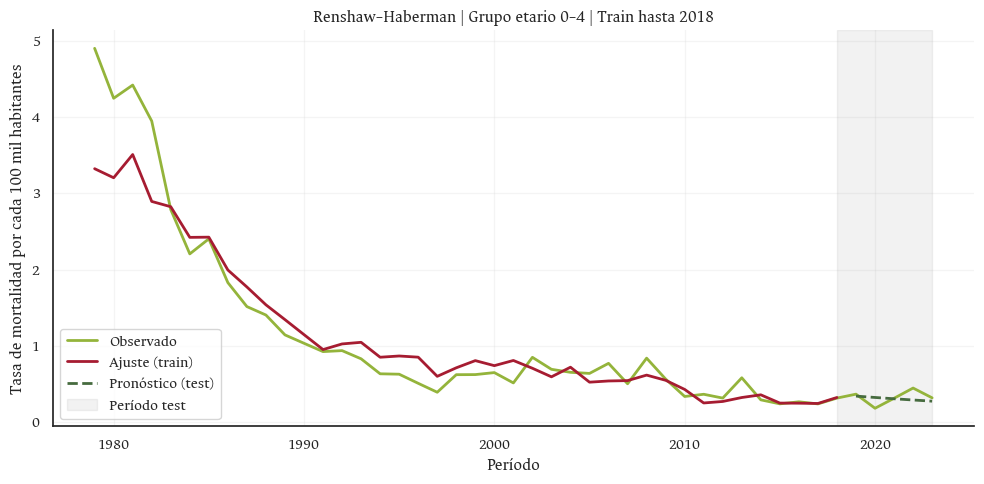

Figura: /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/a_03_lee_carter_renshaw_haberman/renshaw_haberman_forecast_age1.png


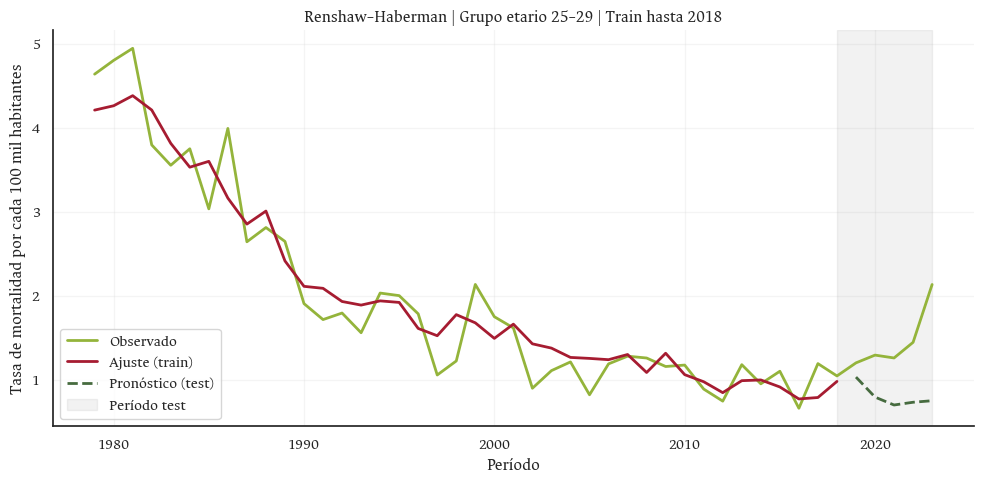

Figura: /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/a_03_lee_carter_renshaw_haberman/renshaw_haberman_forecast_age6.png


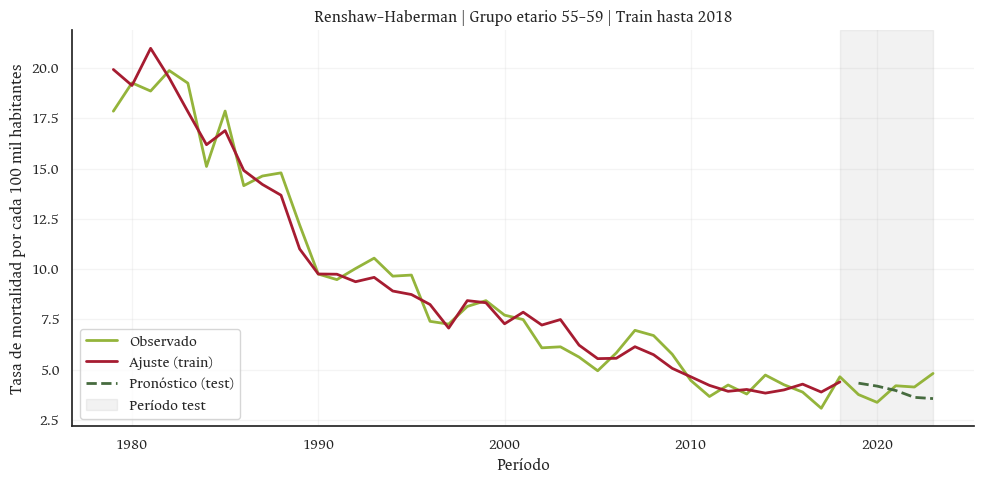

Figura: /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/a_03_lee_carter_renshaw_haberman/renshaw_haberman_forecast_age12.png


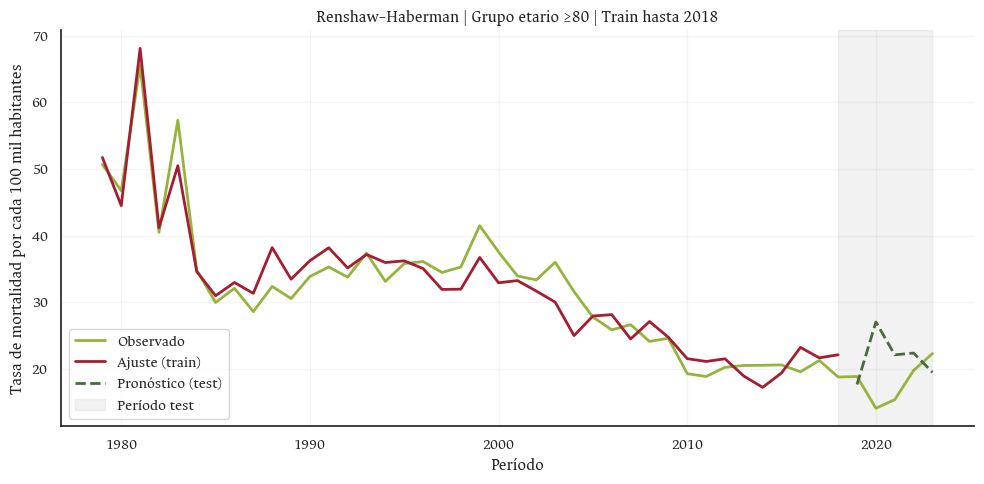

Figura: /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/a_03_lee_carter_renshaw_haberman/renshaw_haberman_forecast_age17.png


In [8]:
# Pronóstico Renshaw–Haberman: split train/test y gráficos por edad
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.arima.model import ARIMA

# Parámetros de experimento
TEST_LAST = 5  # número de años al final para test/pronóstico
AGES_TO_PLOT = [1, 6, 12, 17]  # grupos etarios a mostrar (ajusta a conveniencia)

# Validación de edades
available_ages = set(ages.tolist())
AGES_TO_PLOT = [a for a in AGES_TO_PLOT if a in available_ages]
if not AGES_TO_PLOT:
    AGES_TO_PLOT = [int(ages[0])]  # fallback

# Partición temporal
all_years = years.astype(int)
TRAIN_END_YEAR = int(all_years.max() - TEST_LAST)
train_mask = mat.columns.astype(int) <= TRAIN_END_YEAR
test_mask = ~train_mask

mat_train = mat.loc[:, train_mask]
mat_test = mat.loc[:, test_mask]
# Guardar listas de años por partición para downstream
years_train = mat_train.columns.astype(int).values
years_test = mat_test.columns.astype(int).values

# Construir índices de cohorte para TODO el horizonte (train+test) en índices de posición
X = mat.shape[0]
T_tr = mat_train.shape[1]
T_ts = mat_test.shape[1]
T_full = T_tr + T_ts

age_idx = np.arange(X)
per_idx_full = np.arange(T_full)
D_full = per_idx_full[None, :] - age_idx[:, None]
shift_full = int(-D_full.min())
cohort_idx_full = (D_full + shift_full).astype(int)
C_full = int(cohort_idx_full.max() + 1)

cohort_idx_tr = cohort_idx_full[:, :T_tr]
cohort_idx_ts = cohort_idx_full[:, T_tr:]

# Ajuste RH solo con TRAIN
EPS = 1e-12
logm_tr = np.log(np.clip(mat_train.values, EPS, None))
ax_tr, b_tr, k_tr, c_tr, gamma_full, _ = fit_rh(
    logm_tr, cohort_idx_2d=cohort_idx_tr, C=C_full, max_iter=200, tol=1e-7
)

# Modelo temporal para k_t (RW con drift: ARIMA(0,1,0) con tendencia lineal)
h = T_ts
if h > 0 and len(k_tr) >= 3:
    model = ARIMA(k_tr, order=(0,1,0), trend='t')
    res = model.fit()
    kt_fore = np.asarray(res.forecast(steps=h))
else:
    kt_fore = np.zeros(h)

# Reconstrucción (train y test) con término de cohorte
logm_hat_train = ax_tr[:, None] + np.outer(b_tr, k_tr) + (c_tr[:, None] * gamma_full[cohort_idx_tr])
logm_hat_test = (
    ax_tr[:, None] + np.outer(b_tr, kt_fore) + (c_tr[:, None] * gamma_full[cohort_idx_ts])
) if h > 0 else np.empty((len(ax_tr), 0))

m_hat_train = np.exp(logm_hat_train)  # shape: (X, T_train)
m_hat_test = np.exp(logm_hat_test)    # shape: (X, T_test)

# Armar DataFrame largo por edad y año

def build_df_by_age(age_idx0):
    age_val = ages[age_idx0]
    obs_train = mat_train.iloc[age_idx0, :].values * 1e5
    fit_train = m_hat_train[age_idx0, :] * 1e5
    obs_test = mat_test.iloc[age_idx0, :].values * 1e5 if h > 0 else np.array([])
    fit_test = m_hat_test[age_idx0, :] * 1e5 if h > 0 else np.array([])

    df_tr = pd.DataFrame({
        'age': age_val,
        'age_label': age_label(age_val),
        'year': mat_train.columns.astype(int).values,
        'obs_x100k': obs_train,
        'pred_x100k': fit_train,
        'phase': 'train'
    })
    df_ts = pd.DataFrame({
        'age': age_val,
        'age_label': age_label(age_val),
        'year': mat_test.columns.astype(int).values,
        'obs_x100k': obs_test,
        'pred_x100k': fit_test,
        'phase': 'test'
    }) if h > 0 else pd.DataFrame(columns=df_tr.columns)
    return pd.concat([df_tr, df_ts], ignore_index=True)

# Construir y guardar series para edades seleccionadas
rows = []
for a in AGES_TO_PLOT:
    idx = int(np.where(ages == a)[0][0])
    rows.append(build_df_by_age(idx))

forecast_df = pd.concat(rows, ignore_index=True)
forecast_df['err_abs'] = np.abs(forecast_df['obs_x100k'] - forecast_df['pred_x100k'])
forecast_df['error_pct'] = np.abs(forecast_df['obs_x100k'] - forecast_df['pred_x100k']) / forecast_df['obs_x100k'] * 100.0
forecast_csv = os.path.join(OUT_DIR, "lee_carter_forecast_by_age.csv")
forecast_df.to_csv(forecast_csv, index=False)
print("Guardado:", forecast_csv)

# Gráficos por edad
import matplotlib.dates as mdates
palette3 = get_palette(3)

for a in AGES_TO_PLOT:
    sub = forecast_df[forecast_df['age'] == a].sort_values('year')
    fig, axp = plt.subplots(figsize=(10,5))

    # Observado (todo)
    axp.plot(sub['year'], sub['obs_x100k'], color=palette3[0], label='Observado', linewidth=2)

    # Ajuste (train)
    tr = sub[sub['phase'] == 'train']
    axp.plot(tr['year'], tr['pred_x100k'], color=palette3[1], label='Ajuste (train)', linewidth=2)

    # Pronóstico (test)
    ts = sub[sub['phase'] == 'test']
    if not ts.empty:
        axp.plot(ts['year'], ts['pred_x100k'], color=palette3[2], linestyle='--', label='Pronóstico (test)', linewidth=2)
        axp.axvspan(TRAIN_END_YEAR + 0.0, sub['year'].max(), color='gray', alpha=0.1, label='Período test')

    label_a = age_label(a)
    axp.set_title(f"Renshaw–Haberman | Grupo etario {label_a} | Train hasta {TRAIN_END_YEAR}")
    axp.set_xlabel("Período")
    axp.set_ylabel("Tasa de mortalidad por cada 100 mil habitantes")
    axp.legend()
    axp.grid(alpha=0.2)
    axp.spines['top'].set_visible(False)
    axp.spines['right'].set_visible(False)
    plt.tight_layout()

    out_png = os.path.join(OUT_DIR, f"renshaw_haberman_forecast_age{a}.png")
    fig.savefig(out_png, dpi=150)
    plt.show()
    print("Figura:", out_png)

# Nota: Puedes cambiar TEST_LAST y AGES_TO_PLOT para otros cortes/períodos.


In [9]:
# Métricas por edad y por año (train y test)

# Calculamos métricas desagregadas por grupo etario y por año, separadas para phase=='train' y phase=='test':
# - Métricas: MAE, MAPE, SMAPE (x100k), MSE_x100k, RMSE_x100k, MSE_logm, RMSE_logm.
# - Archivos de salida (CSV) en OUT_DIR con sufijos _by_age_{phase}.csv y _by_year_{phase}.csv.

import numpy as np
import pandas as pd
import os


def _metrics_from_vectors(y_true_100k, y_pred_100k, eps):
    y_true_100k = np.asarray(y_true_100k, dtype=float)
    y_pred_100k = np.asarray(y_pred_100k, dtype=float)
    # MAE
    mae_x100k = float(np.mean(np.abs(y_true_100k - y_pred_100k)))
    # MAPE (%), proteger contra 0
    mask = np.abs(y_true_100k) > (eps * 1e5)
    mape_x100k = (
        float(np.mean(np.abs((y_true_100k[mask] - y_pred_100k[mask]) / y_true_100k[mask])) * 100.0)
        if mask.any() else float('nan')
    )
    # SMAPE (%)
    denom = np.abs(y_true_100k) + np.abs(y_pred_100k)
    sm = np.zeros_like(denom, dtype=float)
    m2 = denom > 0
    sm[m2] = 2.0 * np.abs(y_pred_100k[m2] - y_true_100k[m2]) / denom[m2]
    smape_x100k = float(100.0 * np.mean(sm))
    # MSE / RMSE x100k
    mse_x100k = float(np.mean((y_true_100k - y_pred_100k) ** 2))
    rmse_x100k = float(np.sqrt(mse_x100k))
    # MSE / RMSE en log m
    y_true_m = np.clip(y_true_100k / 1e5, EPS, None)
    y_pred_m = np.clip(y_pred_100k / 1e5, EPS, None)
    log_true = np.log(y_true_m)
    log_pred = np.log(y_pred_m)
    mse_logm = float(np.mean((log_true - log_pred) ** 2))
    rmse_logm = float(np.sqrt(mse_logm))
    return {
        'MAE_x100k': mae_x100k,
        'MAPE_%': mape_x100k,
        'SMAPE_%': smape_x100k,
        'MSE_x100k': mse_x100k,
        'RMSE_x100k': rmse_x100k,
        'MSE_logm': mse_logm,
        'RMSE_logm': rmse_logm,
    }

if 'forecast_df' not in globals() or forecast_df.empty:
    print("No se encontró 'forecast_df' o está vacío. Ejecuta primero la sección de pronóstico.")
else:
    for phase in ['train', 'test']:
        sub = forecast_df[forecast_df['phase'] == phase].copy()
        if sub.empty:
            print(f"No hay filas para phase='{phase}'.")
            continue
        # Por grupo etario
        rows_age = []
        for a in sorted(sub['age'].unique()):
            s = sub[sub['age'] == a]
            y_true_100k = s['obs_x100k'].to_numpy()
            y_pred_100k = s['pred_x100k'].to_numpy()
            met = _metrics_from_vectors(y_true_100k, y_pred_100k, EPS)
            row = {
                'age': int(a),
                'N': int(len(s)),
            }
            if 'age_label' in s.columns:
                row['age_label'] = s['age_label'].iloc[0]
            row.update(met)
            rows_age.append(row)
        df_age = pd.DataFrame(rows_age)
        out_age = os.path.join(OUT_DIR, f'lee_carter_forecast_metrics_by_age_{phase}.csv')
        df_age.to_csv(out_age, index=False)
        print(f"Guardado por edad ({phase}):", out_age)
        display(df_age.head())

        # Por año
        rows_year = []
        for yr in sorted(sub['year'].unique()):
            s = sub[sub['year'] == yr]
            y_true_100k = s['obs_x100k'].to_numpy()
            y_pred_100k = s['pred_x100k'].to_numpy()
            met = _metrics_from_vectors(y_true_100k, y_pred_100k, EPS)
            row = {
                'year': int(yr),
                'N': int(len(s)),
            }
            row.update(met)
            rows_year.append(row)
        df_year = pd.DataFrame(rows_year)
        out_year = os.path.join(OUT_DIR, f'lee_carter_forecast_metrics_by_year_{phase}.csv')
        df_year.to_csv(out_year, index=False)
        print(f"Guardado por año ({phase}):", out_year)
        display(df_year.head())


Guardado por edad (train): /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/a_03_lee_carter_renshaw_haberman/lee_carter_forecast_metrics_by_age_train.csv


,age,N,age_label,MAE_x100k,MAPE_%,SMAPE_%,MSE_x100k,RMSE_x100k,MSE_logm,RMSE_logm
0,1,40,0–4,0.232045,20.224716,19.659727,0.160954,0.401191,0.060652,0.246276
1,6,40,25–29,0.265407,15.704963,14.848803,0.106471,0.326298,0.035178,0.187559
2,12,40,55–59,0.694244,8.537726,8.438335,0.718821,0.847833,0.010097,0.100484
3,17,40,≥80,2.382306,7.848675,7.855689,8.770218,2.961455,0.009467,0.097299


Guardado por año (train): /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/a_03_lee_carter_renshaw_haberman/lee_carter_forecast_metrics_by_year_train.csv


,year,N,MAE_x100k,MAPE_%,SMAPE_%,MSE_x100k,RMSE_x100k,MSE_logm,RMSE_logm
0,1979,4,1.284955,13.783322,15.275223,2.024207,1.422746,0.043225,0.207906
1,1980,4,0.989642,10.318418,11.374690,1.610779,1.269165,0.024010,0.154950
2,1981,4,1.545537,11.802791,12.397629,3.083599,1.756018,0.020195,0.142108
3,1982,4,0.633567,10.304119,11.190692,0.475852,0.689820,0.026964,0.164207
4,1983,4,2.132950,6.982251,7.173593,12.134445,3.483453,0.006769,0.082272


Guardado por edad (test): /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/a_03_lee_carter_renshaw_haberman/lee_carter_forecast_metrics_by_age_test.csv


,age,N,age_label,MAE_x100k,MAPE_%,SMAPE_%,MSE_x100k,RMSE_x100k,MSE_logm,RMSE_logm
0,1,5,0–4,0.074741,27.092348,24.490763,0.009429,0.097104,0.108825,0.329886
1,6,5,25–29,0.665047,42.291221,56.361389,0.602768,0.776382,0.432914,0.657962
2,12,5,55–59,0.675023,16.590522,16.839845,0.571484,0.755965,0.035374,0.188081
3,17,5,≥80,5.251567,33.447215,26.181407,45.712087,6.761071,0.118280,0.343919


Guardado por año (test): /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/a_03_lee_carter_renshaw_haberman/lee_carter_forecast_metrics_by_year_test.csv


,year,N,MAE_x100k,MAPE_%,SMAPE_%,MSE_x100k,RMSE_x100k,MSE_logm,RMSE_logm
0,2019,4,0.487542,10.602548,10.719180,0.440595,0.663774,0.013056,0.114262
1,2020,4,3.595868,57.964382,47.013634,42.057969,6.485212,0.259528,0.509439
2,2021,4,1.880286,23.938942,25.214642,11.379173,3.373303,0.120214,0.346719
3,2022,4,0.994889,27.486766,33.397883,1.883770,1.372505,0.170561,0.412990
4,2023,4,1.374388,29.283995,38.496416,2.858203,1.690622,0.305883,0.553067


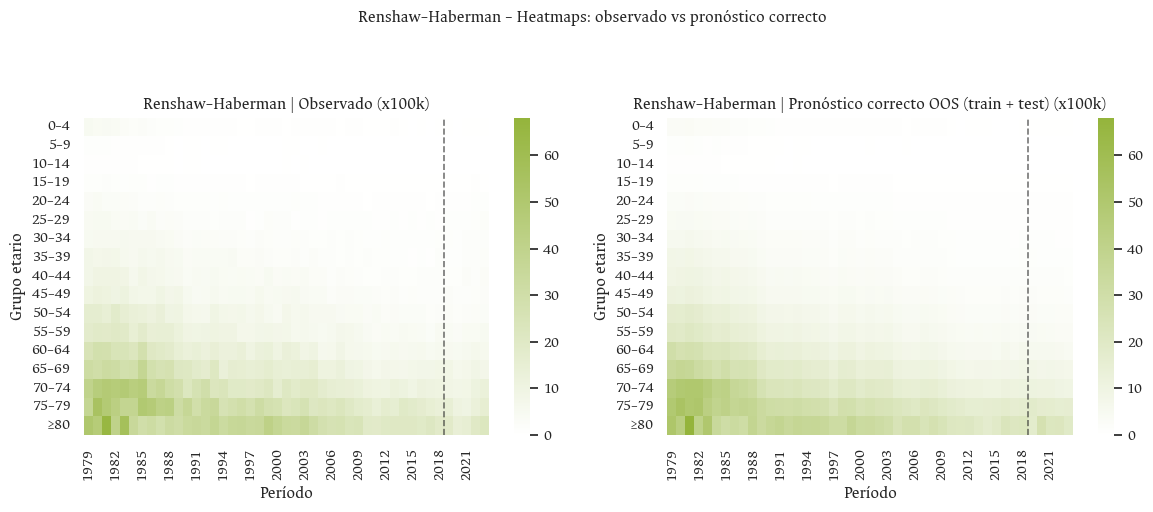

Guardada figura: /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/a_03_lee_carter_renshaw_haberman/lee_carter_heatmaps_obs_vs_forecast_correct.png


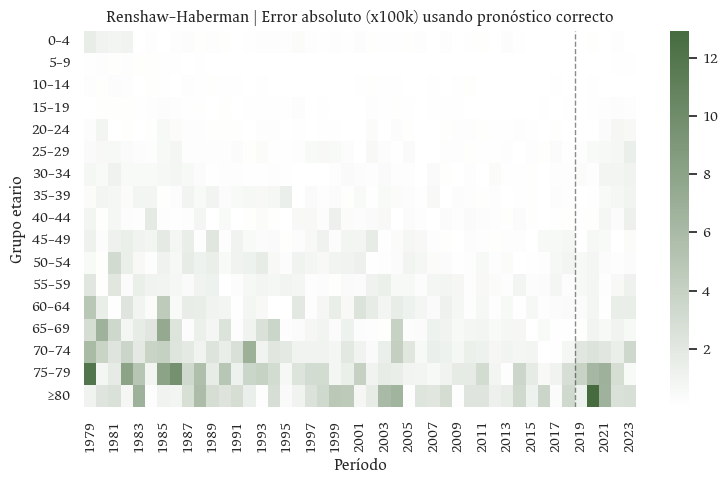

Guardada figura: /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/a_03_lee_carter_renshaw_haberman/lee_carter_heatmap_error_abs_forecast_correct.png


In [14]:
## Heatmaps observado vs pronóstico correcto (train + test)

# Este gráfico replica el formato de los heatmaps iniciales, pero ahora usa el pronóstico correcto
# derivado del split train/test. Se usa la misma escala de color para comparación justa.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Verificaciones mínimas
req = ['m_hat_train','m_hat_test','years_train','years_test','ages','years','OUT_DIR','TRAIN_END_YEAR']
missing = [r for r in req if r not in globals()]
if missing:
    print("Faltan variables en el entorno para construir el pronóstico completo:", missing)
else:
    # Armar la matriz completa de pronóstico (todas las edades × todos los años)
    # Orden temporal: [years_train, years_test]
    pred_full = np.concatenate([m_hat_train, m_hat_test], axis=1) if m_hat_test.size > 0 else m_hat_train
    # Asegurar consistencia de dimensiones
    assert pred_full.shape == (len(ages), len(years)), "Las dimensiones de pred_full no coinciden con (ages × years)."

    obs_100k = mat.values * 1e5
    pred_100k = pred_full * 1e5

    # Determinar una escala común (mismo colormap y mismos límites)
    vmin = 0.0
    vmax = float(np.nanmax([obs_100k.max(), pred_100k.max()]))
    seq = get_sequential_cmap(0)  # mismo color para ambos

    # Heatmaps lado a lado con misma escala
    fig, axes2 = plt.subplots(1,2, figsize=(12,5))

    sns.heatmap(pd.DataFrame(obs_100k, index=ages, columns=years), ax=axes2[0], cmap=seq, vmin=vmin, vmax=vmax)
    axes2[0].set_title("Renshaw–Haberman | Observado (x100k)")
    axes2[0].set_xlabel("Período")
    axes2[0].set_ylabel("Grupo etario")
    axes2[0].set_yticklabels(get_age_labels(ages), rotation=0)
    axes2[0].spines['top'].set_visible(False)
    axes2[0].spines['right'].set_visible(False)

    sns.heatmap(pd.DataFrame(pred_100k, index=ages, columns=years), ax=axes2[1], cmap=seq, vmin=vmin, vmax=vmax)
    axes2[1].set_title("Renshaw–Haberman | Pronóstico correcto OOS (train + test) (x100k)")
    axes2[1].set_xlabel("Período")
    axes2[1].set_ylabel("Grupo etario")
    axes2[1].set_yticklabels(get_age_labels(ages), rotation=0)
    axes2[1].spines['top'].set_visible(False)
    axes2[1].spines['right'].set_visible(False)

    # Línea vertical del corte train/test en ambos paneles
    try:
        years_int = np.asarray(years, dtype=int)
        cut_idx = int(np.where(years_int == int(TRAIN_END_YEAR))[0][0])
        x_cut = cut_idx + 1  # frontera entre la última columna de train y la primera de test
        for axh in axes2:
            axh.axvline(x=x_cut, color='k', linestyle='--', linewidth=1.2, alpha=0.6)
    except Exception as e:
        print("No se pudo dibujar la línea de corte:", e)

    fig.suptitle("Renshaw–Haberman – Heatmaps: observado vs pronóstico correcto", y=1.02, fontsize=12)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    out_png = os.path.join(OUT_DIR, "lee_carter_heatmaps_obs_vs_forecast_correct.png")
    fig.savefig(out_png, dpi=150)
    plt.show()
    print("Guardada figura:", out_png)

    # Heatmap del error absoluto (x100k)
    err_abs_100k = np.abs(obs_100k - pred_100k)
    fig2, ax2 = plt.subplots(figsize=(8,5))
    seq_err = get_sequential_cmap(2)
    sns.heatmap(pd.DataFrame(err_abs_100k, index=ages, columns=years), cmap=seq_err, ax=ax2)
    try:
        ax2.axvline(x=x_cut, color='k', linestyle='--', linewidth=1.0, alpha=0.5)
    except Exception:
        pass
    ax2.set_title("Renshaw–Haberman | Error absoluto (x100k) usando pronóstico correcto")
    ax2.set_xlabel("Período")
    ax2.set_ylabel("Grupo etario")
    ax2.set_yticklabels(get_age_labels(ages), rotation=0)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    plt.tight_layout()
    err_png = os.path.join(OUT_DIR, "lee_carter_heatmap_error_abs_forecast_correct.png")
    fig2.savefig(err_png, dpi=150)
    plt.show()
    print("Guardada figura:", err_png)


In [15]:
### Corrección: métricas por edad usando todas las edades

# Recalculamos las métricas por edad directamente desde las matrices completas (mat_train/m_hat_train y mat_test/m_hat_test)
# para cubrir TODOS los grupos etarios y sobrescribimos los CSVs *_by_age_{phase}.csv.

import numpy as np
import pandas as pd
import os


def _metrics_from_vectors(y_true_100k, y_pred_100k, eps):
    y_true_100k = np.asarray(y_true_100k, dtype=float)
    y_pred_100k = np.asarray(y_pred_100k, dtype=float)
    mae_x100k = float(np.mean(np.abs(y_true_100k - y_pred_100k)))
    mask = np.abs(y_true_100k) > (eps * 1e5)
    mape_x100k = (
        float(np.mean(np.abs((y_true_100k[mask] - y_pred_100k[mask]) / y_true_100k[mask])) * 100.0)
        if mask.any() else float('nan')
    )
    denom = np.abs(y_true_100k) + np.abs(y_pred_100k)
    sm = np.zeros_like(denom, dtype=float)
    m2 = denom > 0
    sm[m2] = 2.0 * np.abs(y_pred_100k[m2] - y_true_100k[m2]) / denom[m2]
    smape_x100k = float(100.0 * np.mean(sm))
    mse_x100k = float(np.mean((y_true_100k - y_pred_100k) ** 2))
    rmse_x100k = float(np.sqrt(mse_x100k))
    y_true_m = np.clip(y_true_100k / 1e5, EPS, None)
    y_pred_m = np.clip(y_pred_100k / 1e5, EPS, None)
    log_true = np.log(y_true_m)
    log_pred = np.log(y_pred_m)
    mse_logm = float(np.mean((log_true - log_pred) ** 2))
    rmse_logm = float(np.sqrt(mse_logm))
    return {
        'MAE_x100k': mae_x100k,
        'MAPE_%': mape_x100k,
        'SMAPE_%': smape_x100k,
        'MSE_x100k': mse_x100k,
        'RMSE_x100k': rmse_x100k,
        'MSE_logm': mse_logm,
        'RMSE_logm': rmse_logm,
    }


def _compute_by_age_from_mats(mat_df, mhat_arr, ages_vec, eps):
    rows = []
    for i, a in enumerate(ages_vec):
        y_true_100k = mat_df.iloc[i, :].to_numpy(dtype=float) * 1e5
        y_pred_100k = mhat_arr[i, :] * 1e5
        met = _metrics_from_vectors(y_true_100k, y_pred_100k, eps)
        row = {'age': int(a), 'N': int(y_true_100k.size), 'age_label': age_label(int(a))}
        row.update(met)
        rows.append(row)
    return pd.DataFrame(rows)

# Validaciones mínimas
req = ['mat_train','mat_test','m_hat_train','m_hat_test','ages','OUT_DIR']
missing = [r for r in req if r not in globals()]
if missing:
    print("Faltan variables requeridas:", missing)
else:
    # Train
    df_age_train_full = _compute_by_age_from_mats(mat_train, m_hat_train, ages, EPS)
    out_age_tr = os.path.join(OUT_DIR, 'lee_carter_forecast_metrics_by_age_train.csv')
    df_age_train_full.to_csv(out_age_tr, index=False)
    print("Recalculado y guardado (por edad - train):", out_age_tr)
    display(df_age_train_full.head())

    # Test (si existe)
    if m_hat_test.size > 0 and mat_test.shape[1] > 0:
        df_age_test_full = _compute_by_age_from_mats(mat_test, m_hat_test, ages, EPS)
        out_age_ts = os.path.join(OUT_DIR, 'lee_carter_forecast_metrics_by_age_test.csv')
        df_age_test_full.to_csv(out_age_ts, index=False)
        print("Recalculado y guardado (por edad - test):", out_age_ts)
        display(df_age_test_full.head())
    else:
        print("No hay período de prueba (h=0): se omite el cálculo por edad para test.")


Recalculado y guardado (por edad - train): /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/a_03_lee_carter_renshaw_haberman/lee_carter_forecast_metrics_by_age_train.csv


,age,N,age_label,MAE_x100k,MAPE_%,SMAPE_%,MSE_x100k,RMSE_x100k,MSE_logm,RMSE_logm
0,1,40,0–4,0.232045,20.224716,19.659727,0.160954,0.401191,0.060652,0.246276
1,2,40,5–9,0.037425,10.458255,9.753169,0.003909,0.062524,0.014354,0.119807
2,3,40,10–14,0.067248,28.983205,27.267311,0.008288,0.091039,0.119953,0.346343
3,4,40,15–19,0.083745,12.307236,12.274778,0.012182,0.110370,0.023750,0.154110
4,5,40,20–24,0.145934,10.647912,10.564546,0.048061,0.219229,0.019374,0.139192


Recalculado y guardado (por edad - test): /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/a_03_lee_carter_renshaw_haberman/lee_carter_forecast_metrics_by_age_test.csv


,age,N,age_label,MAE_x100k,MAPE_%,SMAPE_%,MSE_x100k,RMSE_x100k,MSE_logm,RMSE_logm
0,1,5,0–4,0.074741,27.092348,24.490763,0.009429,0.097104,0.108825,0.329886
1,2,5,5–9,0.040209,83.416363,51.238079,0.002205,0.046954,0.486491,0.697489
2,3,5,10–14,0.039469,31.541090,38.077081,0.001735,0.041652,0.164570,0.405672
3,4,5,15–19,0.148323,30.473838,37.860048,0.029886,0.172875,0.197128,0.443991
4,5,5,20–24,0.340335,30.432677,39.403121,0.184814,0.429900,0.255362,0.505333


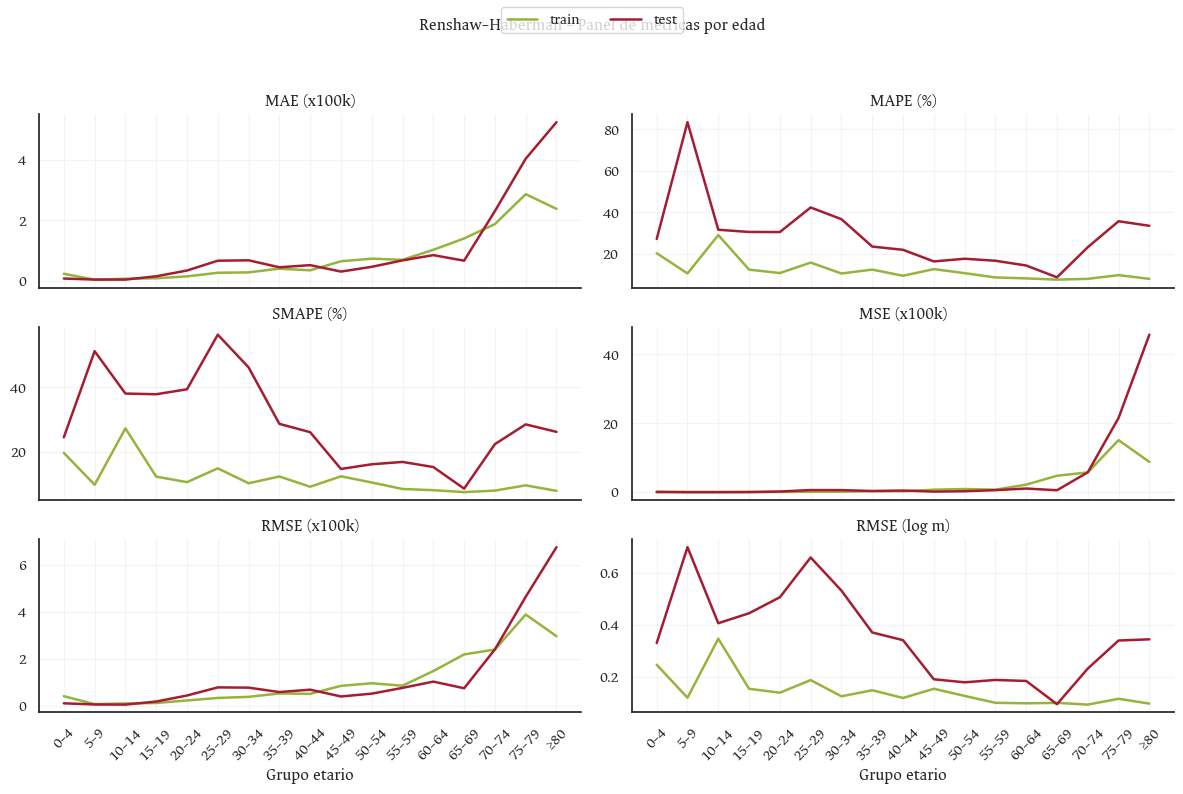

Guardado: /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/a_03_lee_carter_renshaw_haberman/lee_carter_metrics_panels_by_age.png


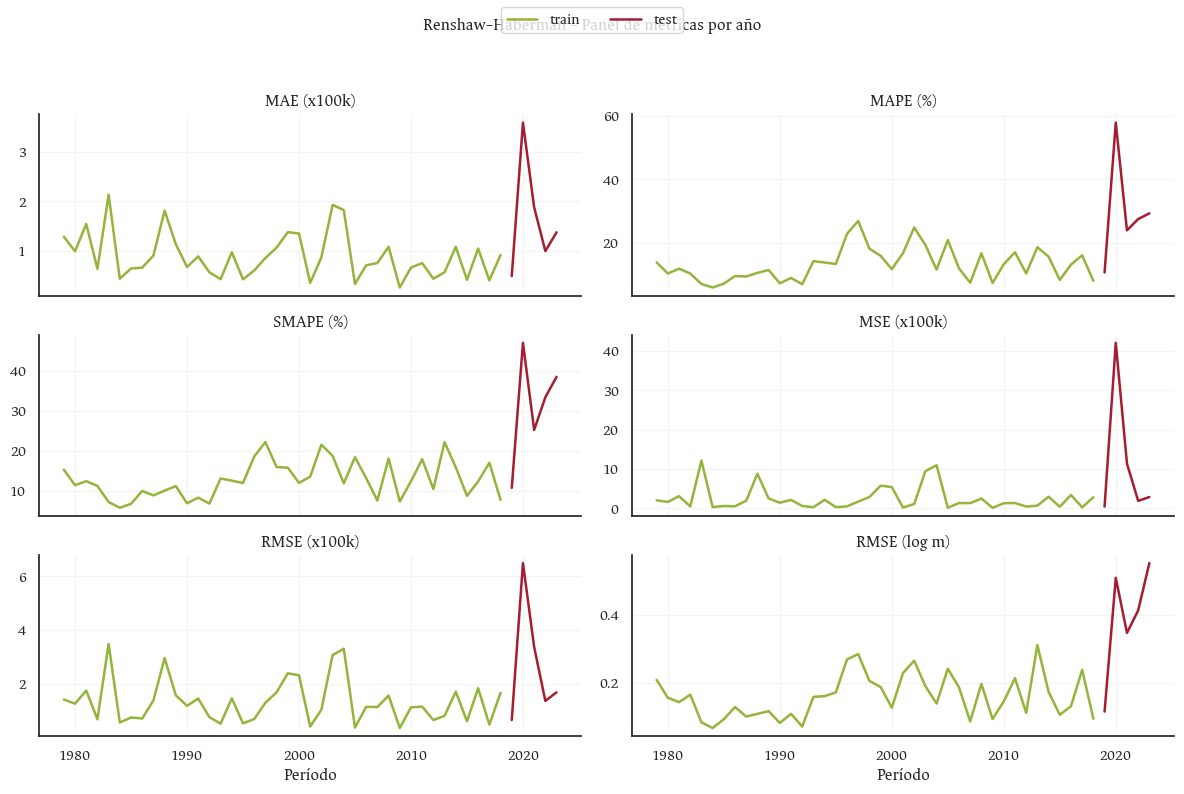

Guardado: /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/a_03_lee_carter_renshaw_haberman/lee_carter_metrics_panels_by_year.png


In [16]:
## Paneles de métricas por edad y por período (train vs test)

# Construimos dos figuras (12×8):
# - Panel por edad (x = grupos etarios), comparando train vs test para 6 métricas.
# - Panel por período (x = años), comparando train vs test para las mismas métricas.
# Se guardan PNGs en OUT_DIR.

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

palette2 = get_palette(2)  # [train, test]


def _plot_panels(df_tr, df_ts, xcol, xlabel, out_png):
    metrics = [
        ('MAE_x100k', 'MAE (x100k)'),
        ('MAPE_%', 'MAPE (%)'),
        ('SMAPE_%', 'SMAPE (%)'),
        ('MSE_x100k', 'MSE (x100k)'),
        ('RMSE_x100k', 'RMSE (x100k)'),
        ('RMSE_logm', 'RMSE (log m)'),
    ]
    fig, axes = plt.subplots(3, 2, figsize=(12, 8), sharex='col')
    axes = axes.reshape(3, 2)

    unique_x = None
    if xcol == 'age':
        if df_ts is not None and not df_ts.empty:
            unique_x = sorted(set(df_tr[xcol].tolist()) | set(df_ts[xcol].tolist()))
        else:
            unique_x = sorted(df_tr[xcol].unique().tolist())

    for i, (met, title) in enumerate(metrics):
        r, c = divmod(i, 2)
        ax = axes[r, c]
        ax.plot(df_tr[xcol], df_tr[met], label='train', color=palette2[0], linewidth=1.8)
        if df_ts is not None and not df_ts.empty:
            ax.plot(df_ts[xcol], df_ts[met], label='test', color=palette2[1], linewidth=1.8)
        ax.set_title(title)
        ax.grid(alpha=0.2)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        if r < 2:
            ax.tick_params(labelbottom=False)
        else:
            ax.set_xlabel(xlabel)

    if xcol == 'age' and unique_x is not None:
        for c in range(2):
            set_age_ticks(axes[2, c], unique_x, 'x')

    handles, labels = axes[0,0].get_legend_handles_labels()
    if handles:
        fig.legend(handles, labels, loc='upper center', ncol=2)
    fig.suptitle(f"Renshaw–Haberman – Panel de métricas por {'edad' if xcol=='age' else 'año'}", y=0.98, fontsize=12)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    fig.savefig(out_png, dpi=150)
    plt.show()
    print("Guardado:", out_png)

# Panel por edad
age_tr_csv = os.path.join(OUT_DIR, 'lee_carter_forecast_metrics_by_age_train.csv')
age_ts_csv = os.path.join(OUT_DIR, 'lee_carter_forecast_metrics_by_age_test.csv')
if os.path.exists(age_tr_csv):
    df_age_tr = pd.read_csv(age_tr_csv).sort_values('age')
    if os.path.exists(age_ts_csv):
        df_age_ts = pd.read_csv(age_ts_csv).sort_values('age')
    else:
        df_age_ts = pd.DataFrame(columns=df_age_tr.columns)
    out_age_png = os.path.join(OUT_DIR, 'lee_carter_metrics_panels_by_age.png')
    _plot_panels(df_age_tr, df_age_ts, xcol='age', xlabel='Grupo etario', out_png=out_age_png)
else:
    print("No se encontró el CSV por edad. Ejecuta antes el cálculo de métricas.")

# Panel por año
year_tr_csv = os.path.join(OUT_DIR, 'lee_carter_forecast_metrics_by_year_train.csv')
year_ts_csv = os.path.join(OUT_DIR, 'lee_carter_forecast_metrics_by_year_test.csv')
if os.path.exists(year_tr_csv):
    df_year_tr = pd.read_csv(year_tr_csv).sort_values('year')
    if os.path.exists(year_ts_csv):
        df_year_ts = pd.read_csv(year_ts_csv).sort_values('year')
    else:
        df_year_ts = pd.DataFrame(columns=df_year_tr.columns)
    out_year_png = os.path.join(OUT_DIR, 'lee_carter_metrics_panels_by_year.png')
    _plot_panels(df_year_tr, df_year_ts, xcol='year', xlabel='Período', out_png=out_year_png)
else:
    print("No se encontró el CSV por año. Ejecuta antes el cálculo de métricas.")


In [17]:
# Duplicar salidas con prefijo 'rh_*' para el modelo Renshaw–Haberman
import os
import shutil

# Mapa de archivos lee_carter_* -> rh_*
rename_map = {
    'lee_carter_forecast_by_age.csv': 'rh_forecast_by_age.csv',
    'lee_carter_forecast_metrics_by_age_train.csv': 'rh_forecast_metrics_by_age_train.csv',
    'lee_carter_forecast_metrics_by_age_test.csv': 'rh_forecast_metrics_by_age_test.csv',
    'lee_carter_forecast_metrics_by_year_train.csv': 'rh_forecast_metrics_by_year_train.csv',
    'lee_carter_forecast_metrics_by_year_test.csv': 'rh_forecast_metrics_by_year_test.csv',
    'lee_carter_heatmaps_obs_vs_forecast_correct.png': 'rh_heatmaps_obs_vs_forecast_correct.png',
    'lee_carter_heatmap_error_abs_forecast_correct.png': 'rh_heatmap_error_abs_forecast_correct.png',
    'lee_carter_metrics_panels_by_age.png': 'rh_metrics_panels_by_age.png',
    'lee_carter_metrics_panels_by_year.png': 'rh_metrics_panels_by_year.png',
}

# También duplicar los PNG individuales de pronóstico por edad, si existen
for a in AGES_TO_PLOT:
    src = os.path.join(OUT_DIR, f"renshaw_haberman_forecast_age{a}.png")
    dst = os.path.join(OUT_DIR, f"rh_forecast_age{a}.png")
    if os.path.exists(src):
        shutil.copy2(src, dst)
        print("Copiado:", dst)

for src_name, dst_name in rename_map.items():
    src = os.path.join(OUT_DIR, src_name)
    dst = os.path.join(OUT_DIR, dst_name)
    if os.path.exists(src):
        shutil.copy2(src, dst)
        print("Copiado:", dst)
    else:
        print("No encontrado (omitido):", src)


Copiado: /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/a_03_lee_carter_renshaw_haberman/rh_forecast_age1.png
Copiado: /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/a_03_lee_carter_renshaw_haberman/rh_forecast_age6.png
Copiado: /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/a_03_lee_carter_renshaw_haberman/rh_forecast_age12.png
Copiado: /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/a_03_lee_carter_renshaw_haberman/rh_forecast_age17.png
Copiado: /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/a_03_lee_carter_renshaw_haberman/rh_forecast_by_age.csv
Copiado: /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/a_03_lee_carter_renshaw_haberman/rh_forecast_metrics_by_age_train.csv
Copiado: /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/a_03_lee_carter_renshaw_haberman/rh_forecast_metrics_b

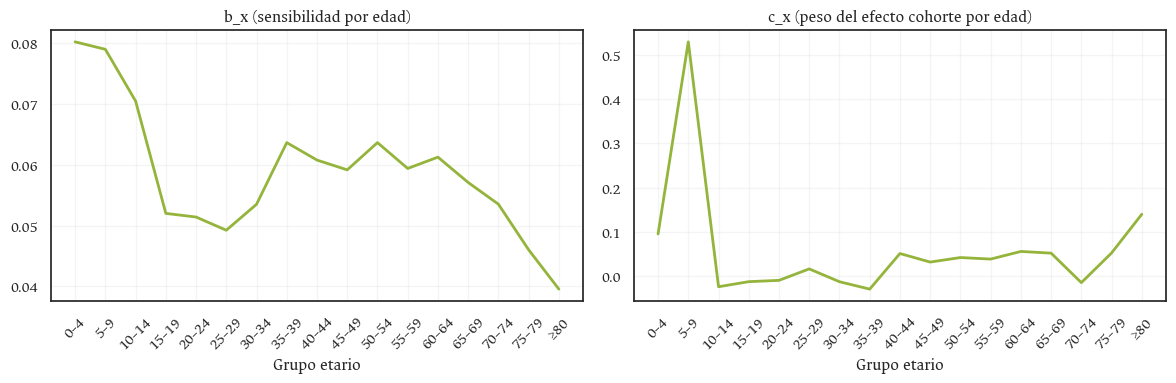

Guardado: /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/a_03_lee_carter_renshaw_haberman/rh_components_bx_cx.png


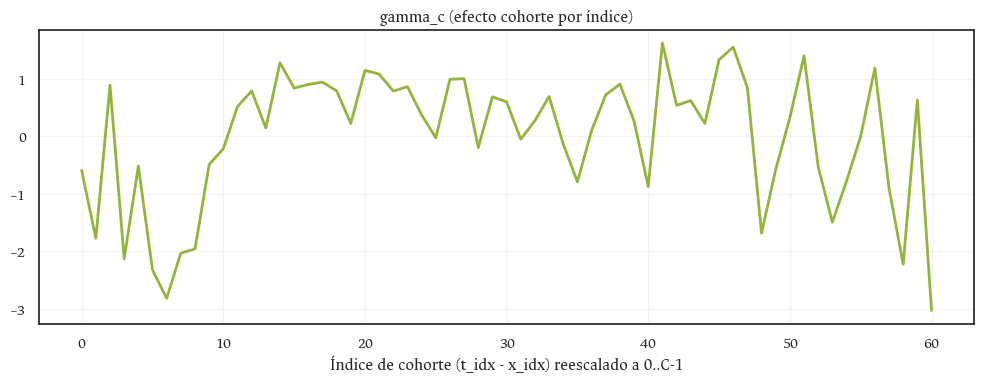

Guardado: /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/a_03_lee_carter_renshaw_haberman/rh_components_gamma.png


In [18]:
# Componentes del modelo RH: b_x, c_x y gamma_c
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Validaciones mínimas
req = ['ages','b','c','gamma','OUT_DIR']
missing = [r for r in req if r not in globals()]
if missing:
    print("Faltan variables para graficar componentes:", missing)
else:
    ages_int = ages.astype(int)
    # b_x y c_x por edad
    fig, axes = plt.subplots(1,2, figsize=(12,4), sharex=True)
    axes[0].plot(ages_int, b, color=get_palette(1)[0], linewidth=2)
    axes[0].set_title('b_x (sensibilidad por edad)')
    axes[0].set_xlabel('Grupo etario')
    axes[0].grid(alpha=0.2)
    set_age_ticks(axes[0], ages_int, 'x')

    axes[1].plot(ages_int, c, color=get_palette(1)[0], linewidth=2)
    axes[1].set_title('c_x (peso del efecto cohorte por edad)')
    axes[1].set_xlabel('Grupo etario')
    axes[1].grid(alpha=0.2)
    set_age_ticks(axes[1], ages_int, 'x')

    plt.tight_layout()
    out_components_age = os.path.join(OUT_DIR, 'rh_components_bx_cx.png')
    fig.savefig(out_components_age, dpi=150)
    plt.show()
    print('Guardado:', out_components_age)

    # gamma_c por índice de cohorte
    fig2, axg = plt.subplots(figsize=(10,4))
    axg.plot(np.arange(len(gamma)), gamma, color=get_palette(1)[0], linewidth=2)
    axg.set_title('gamma_c (efecto cohorte por índice)')
    axg.set_xlabel('Índice de cohorte (t_idx - x_idx) reescalado a 0..C-1')
    axg.grid(alpha=0.2)
    plt.tight_layout()
    out_gamma = os.path.join(OUT_DIR, 'rh_components_gamma.png')
    fig2.savefig(out_gamma, dpi=150)
    plt.show()
    print('Guardado:', out_gamma)


## Resumen de salidas generadas (Renshaw–Haberman)

- CSV:
  - `rh_forecast_by_age.csv`
  - `rh_forecast_metrics_by_age_train.csv`, `rh_forecast_metrics_by_age_test.csv`
  - `rh_forecast_metrics_by_year_train.csv`, `rh_forecast_metrics_by_year_test.csv`
- Figuras RH:
  - `rh_forecast_age{...}.png` (por grupo etario seleccionado)
  - `rh_heatmaps_obs_vs_forecast_correct.png`, `rh_heatmap_error_abs_forecast_correct.png`
  - `rh_metrics_panels_by_age.png`, `rh_metrics_panels_by_year.png`
  - `rh_components_bx_cx.png`, `rh_components_gamma.png`
- Compatibilidad (también disponibles con prefijo `lee_carter_*` para pipelines existentes).

Todas las salidas se guardan en `OUT_DIR`: `modelos/outputs/output/a_03_lee_carter_renshaw_haberman/`. 